# Set Up

In [1]:
# Basic imports
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine learning imports
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

# Financial imports
import yfinance as yf
import pandas_datareader as pdr

# Setting random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Data Loading

In [2]:
def load_data():
    """
    Load gold futures data from a CSV file.
    
    Parameters:
        file_path (str): Path to the CSV file containing gold futures data
        
    Returns:
        DataFrame: Pandas DataFrame with loaded data
    """
    
    data = pd.read_csv('./data/gold_futures.csv',index_col = 0, parse_dates=True)
    # Convert 'Price' to numeric
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data.sort_index(inplace=True)

    dxy = pd.read_csv('./data/dxy.csv',index_col = 0, parse_dates=True)
    real_yields = pd.read_csv('./data/real_yields.csv',index_col = 0, parse_dates=True)
    vix = pd.read_csv('./data/vix.csv',index_col = 0, parse_dates=True)

    merged_data = data.join([dxy, real_yields, vix], how='left').ffill()

    return merged_data

# Training & Test Split

In [3]:
def prepare_training_data(data, train_ratio=0.95, features = ["Price"]):
    """
    Extract feature columns and split data into training and testing sets.
    
    Parameters:
        data (DataFrame): Preprocessed data
        train_ratio (float): Ratio of data to use for training (default: 0.95)
        
    Returns:
        tuple: (training data, test data, scaler)
    """
    data = data[features].copy()
    dataset = data.values
    
    # Determine train/test split point
    training_size = int(np.ceil(len(dataset) * train_ratio))
    
    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(dataset)
    
    # Split into train and test sets
    train_data = scaled_data[:training_size]
    test_data = scaled_data[training_size:]
    
    return train_data, test_data, scaler

In [4]:
def create_sequences(data, seq_length, target_col=0):
    """
    Create sequences for LSTM model input with multiple features.
    
    Parameters:
        data (ndarray): Input data array where columns are features
        seq_length (int): Length of sequence for LSTM input
        target_col (int): Index of the target column to predict
        
    Returns:
        tuple: (X sequences, y targets)
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, target_col].reshape(1))
    
    return np.array(X), np.array(y)

# Model

In [5]:
def build_model(input_shape):
    """
    Build and compile LSTM model.
    
    Parameters:
        input_shape (tuple): Shape of input data
        
    Returns:
        Model: Compiled LSTM model
    """
    from keras.models import Sequential
    from keras.layers import LSTM, Dense, Dropout, Input
    from keras import regularizers
    from keras.metrics import RootMeanSquaredError
    from keras.optimizers import Adam
    
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(LSTM(units=64))
    model.add(Dense(128, kernel_regularizer=regularizers.L2(0.002)))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))

    learning_rate = 0.0008
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[RootMeanSquaredError()])
    
    return model

In [6]:
def train_model(model, X_train, y_train, epochs=40):
    """
    Train the LSTM model.
    
    Parameters:
        model: LSTM model to train
        X_train (ndarray): Training features
        y_train (ndarray): Training targets
        epochs (int): Number of training epochs
        batch_size (int): Batch size for training
        
    Returns:
        History: Training history
    """
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau

    # Early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        verbose=1,
        callbacks=[early_stopping, reduce_lr], 
        validation_split=0.2
    )
    return history

# Evaluation

In [7]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error.
    
    Parameters:
        y_true (array): Actual values
        y_pred (array): Predicted values
        
    Returns:
        float: MAPE value as percentage
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

In [8]:
def evaluate_model(model, X_test, y_test, scaler, target_col=0):
    """
    Evaluate model performance on test data with multiple features.
    
    Parameters:
        model: Trained model
        X_test (ndarray): Test features
        y_test (ndarray): Test targets (single column)
        scaler: Fitted scaler for inverse transformation
        target_col (int): Index of the target column
        
    Returns:
        tuple: (predictions DataFrame, MAPE score)
    """
    # Make predictions
    pred = model.predict(X_test)
    
    # Create templates for inverse transformation
    y_test_template = np.zeros((len(y_test), scaler.n_features_in_))
    pred_template = np.zeros((len(pred), scaler.n_features_in_))
    
    # Place the predictions and actual values in the right column
    y_test_template[:, target_col] = y_test.flatten()
    pred_template[:, target_col] = pred.flatten()
    
    # Inverse transform to get actual values
    y_test_inv = scaler.inverse_transform(y_test_template)[:, target_col]
    pred_inv = scaler.inverse_transform(pred_template)[:, target_col]
    
    # Create results DataFrame
    test = pd.DataFrame({
        'actual': y_test_inv,
        'pred': pred_inv
    })
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(test['actual'], test['pred'])
    
    return test, mape

In [9]:
def plot_results(actual, predicted, title="Gold Futures Price Prediction"):
    """
    Plot actual vs predicted values.
    
    Parameters:
        actual (array): Actual price values
        predicted (array): Predicted price values
        title (str): Plot title
    """
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual Prices')
    plt.plot(predicted, label='Predicted Prices')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Run

## Model 1

Epoch 1/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.3991 - root_mean_squared_error: 0.4530 - val_loss: 0.1836 - val_root_mean_squared_error: 0.2264 - learning_rate: 8.0000e-04
Epoch 2/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1420 - root_mean_squared_error: 0.1402 - val_loss: 0.1107 - val_root_mean_squared_error: 0.1255 - learning_rate: 8.0000e-04
Epoch 3/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1038 - root_mean_squared_error: 0.1280 - val_loss: 0.0748 - val_root_mean_squared_error: 0.0852 - learning_rate: 8.0000e-04
Epoch 4/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0788 - root_mean_squared_error: 0.1287 - val_loss: 0.0595 - val_root_mean_squared_error: 0.1066 - learning_rate: 8.0000e-04
Epoch 5/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0590 - root_mean_squared_error: 0.1206 - val_loss: 0.0424 - val_root_mean_squared_error: 0.0891 - learning_rate: 8.0000e-04
Epoch 6/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0453 -

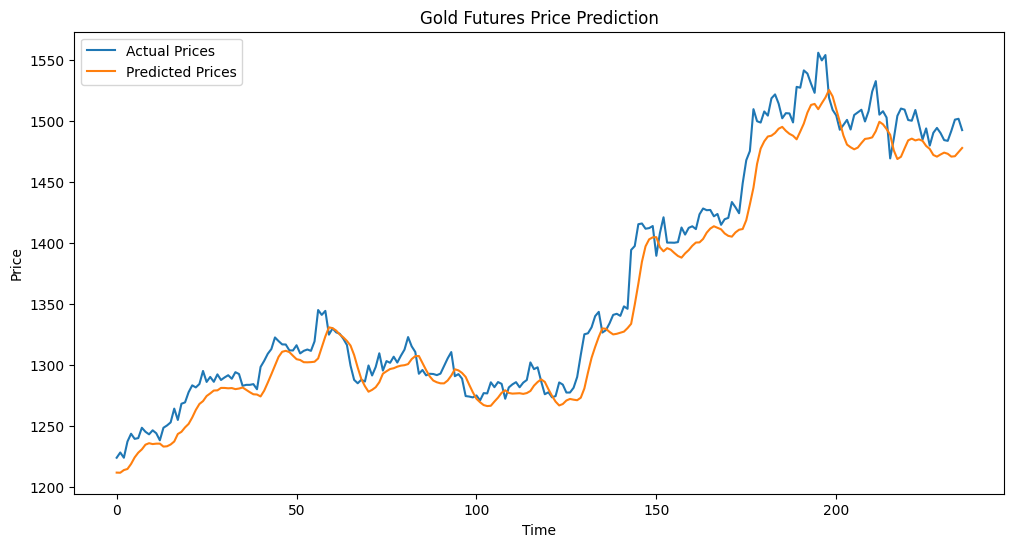

In [12]:
# Load and prepare data
data = load_data()

# Specify which features to use
features = ["Price", "DXY", "VIX"]  # Update with your actual column names

# Prepare training data
train_data, test_data, scaler = prepare_training_data(data, train_ratio=0.95, features=features)

# Create sequences
seq_length = 14  # Example sequence length
target_col = 0  # Index of the target column (Price is the first column)
X_train, y_train = create_sequences(train_data, seq_length, target_col)
X_test, y_test = create_sequences(test_data, seq_length, target_col)

# Build and train model
model = build_model(input_shape=(X_train.shape[1], X_train.shape[2]))
history = train_model(model, X_train, y_train)

# Evaluate model
test_results, mape = evaluate_model(model, X_test, y_test, scaler, target_col)

# Print results
print(f"MAPE: {mape:.2f}%")

# Plot results
plot_results(test_results['actual'], test_results['pred'], title="Gold Futures Price Prediction")